In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from sklearn.model_selection import ParameterGrid
from datetime import time

from etr.auto_import import *
from etr.data.data_loader import load_data, list_hdb

# Data

In [12]:
syms = ["XRP"]
years = [2023, 2024, 2025]
parent_dir = Path(f"../../data/gmo/")

gmo = []
for sym in tqdm(syms):
    for year in years:
        gmo += [pd.read_parquet(file) for file in parent_dir.glob(f"{sym}/{year}*.parquet")]
gmo = pd.concat(gmo)

100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


## preprocess

In [14]:
close_1m = gmo.set_index("timestamp").groupby("symbol").price.resample("30s", label="right").last().unstack(level=0).ffill()

In [15]:
exec_price = gmo.set_index("timestamp").groupby(["side"]).price.resample("30s").agg(["min", "max"])
exec_price = exec_price.unstack(level=[0])
exec_price = exec_price.loc[:, ix["min", "SELL"]].to_frame("sell_price").join(exec_price.loc[:, ix["max", "BUY"]].to_frame("buy_price"))
# exec_price.columns = ["_".join(c).lower() for c in exec_price.columns]

In [156]:
ccy_pair = "XRP"
data = close_1m[[ccy_pair]].set_axis(["close"], axis=1).join(exec_price)
data.head(3)

,close,sell_price,buy_price
timestamp,,,
2022-12-31 21:00:30,45.030,NaN,45.036
2022-12-31 21:01:00,45.036,NaN,NaN
2022-12-31 21:01:30,45.036,NaN,45.060


In [150]:
interval1 = [time(1, 30), time(5, 30)]
interval2 = [time(7, 0), time(12, 30)]
# interval3 = [time(12, 0), time(16, 20)]
interval4 = [time(16, 20), time(20, 30)]

---
### 1630 - 2030

,count,mean,std,min,25%,50%,75%,max
ret,851.0,27.907119,229.006806,-1694.734804,-44.481811,26.351308,92.211226,3384.367542


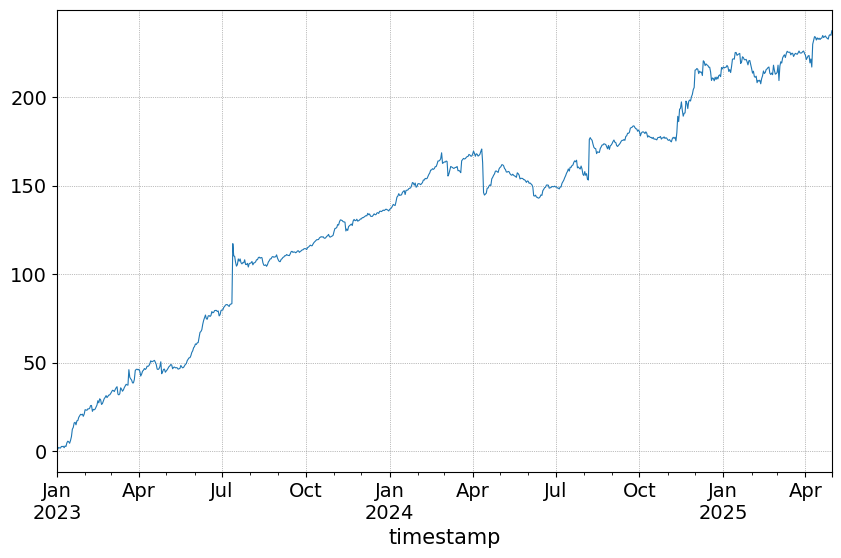

In [227]:
from datetime import time
raw_ret = close_1m.XRP.between_time(time(16, 30), time(20, 30)).resample("1D").agg(["first", "last"]).pct_change(axis=1).iloc[:, -1].rename("ret").mul(1e4)
raw_ret.cumsum().div(1e2).plot();
raw_ret.describe().to_frame().T

In [228]:
# Run
from etr.research.tod.v1 import run_tod

results = []
for params in tqdm(ParameterGrid({
    "sl_level": [np.nan, 300, 500],
    "entry_duration": [0, 5],
    "exit_duration": [0, 5],
    "entry_offset": [0, 1, 3, 5],
    "exit_offset": [0, 1, 3, 5],
})):
    trs = run_tod(data, st=time(16, 25), et=time(20, 35), **params).set_index("timestamp")
    assert trs.entry_side.eq(1).all()
    desc = trs.pl.describe().rename(lambda x: f"pl_{x}")
    desc["sharpe"] = desc["pl_mean"] / desc["pl_std"] * np.sqrt(365)
    desc["MDD"] = (trs.pl.cumsum() - trs.pl.cumsum().cummax()).min() / 1e2
    desc = desc.rename(str(params)).to_frame().T
    results.append(desc)

results = pd.concat(results)
params = pd.DataFrame(results.rename(lambda x: eval(x.replace("nan", "None"))).index.tolist())
params = params.set_index(results.index)
results = results.join(params)

100%|██████████| 192/192 [03:20<00:00,  1.05s/it]


In [229]:
results.sort_values("sharpe", ascending=False).drop_duplicates("pl_mean").head(10).style.format(precision=2)

,pl_count,pl_mean,pl_std,pl_min,pl_25%,pl_50%,pl_75%,pl_max,sharpe,MDD,entry_duration,entry_offset,exit_duration,exit_offset,sl_level
"{'entry_duration': 0, 'entry_offset': 0, 'exit_duration': 0, 'exit_offset': 0, 'sl_level': nan}",851.00,21.85,231.42,-1531.01,-52.35,17.37,85.65,3382.55,1.80,-30.86,0,0,0,0,nan
"{'entry_duration': 0, 'entry_offset': 5, 'exit_duration': 0, 'exit_offset': 5, 'sl_level': 500}",851.00,20.92,234.32,-503.80,-53.31,17.09,84.63,4223.92,1.71,-29.69,0,5,0,5,500.00
"{'entry_duration': 5, 'entry_offset': 5, 'exit_duration': 0, 'exit_offset': 0, 'sl_level': nan}",851.00,18.38,230.22,-1528.65,-54.03,14.84,83.04,3394.54,1.53,-35.02,5,5,0,0,nan
"{'entry_duration': 0, 'entry_offset': 3, 'exit_duration': 5, 'exit_offset': 5, 'sl_level': 500}",851.00,18.46,236.23,-503.80,-54.71,15.49,82.25,4223.92,1.49,-39.70,0,3,5,5,500.00
"{'entry_duration': 0, 'entry_offset': 1, 'exit_duration': 5, 'exit_offset': 5, 'sl_level': nan}",851.00,17.82,231.38,-1689.39,-54.16,15.54,82.70,3351.04,1.47,-35.52,0,1,5,5,nan
"{'entry_duration': 5, 'entry_offset': 3, 'exit_duration': 0, 'exit_offset': 5, 'sl_level': nan}",851.00,17.73,230.17,-1530.39,-55.41,15.26,82.54,3391.98,1.47,-35.64,5,3,0,5,nan
"{'entry_duration': 0, 'entry_offset': 0, 'exit_duration': 5, 'exit_offset': 0, 'sl_level': 500}",851.00,17.95,235.89,-503.80,-54.00,13.12,81.15,4223.92,1.45,-39.80,0,0,5,0,500.00
"{'entry_duration': 0, 'entry_offset': 1, 'exit_duration': 5, 'exit_offset': 3, 'sl_level': 500}",851.00,17.89,235.97,-503.80,-55.99,15.11,81.05,4223.92,1.45,-40.86,0,1,5,3,500.00
"{'entry_duration': 5, 'entry_offset': 0, 'exit_duration': 0, 'exit_offset': 5, 'sl_level': nan}",851.00,17.44,230.16,-1532.95,-56.10,14.04,82.29,3387.82,1.45,-36.05,5,0,0,5,nan
"{'entry_duration': 5, 'entry_offset': 5, 'exit_duration': 0, 'exit_offset': 5, 'sl_level': 500}",851.00,17.50,233.23,-503.80,-54.64,14.71,82.36,4236.66,1.43,-30.88,5,5,0,5,500.00


---
### 0130-0530

,count,mean,std,min,25%,50%,75%,max
ret,851.0,19.659239,146.480397,-742.132639,-43.619468,11.340657,76.424067,913.606478


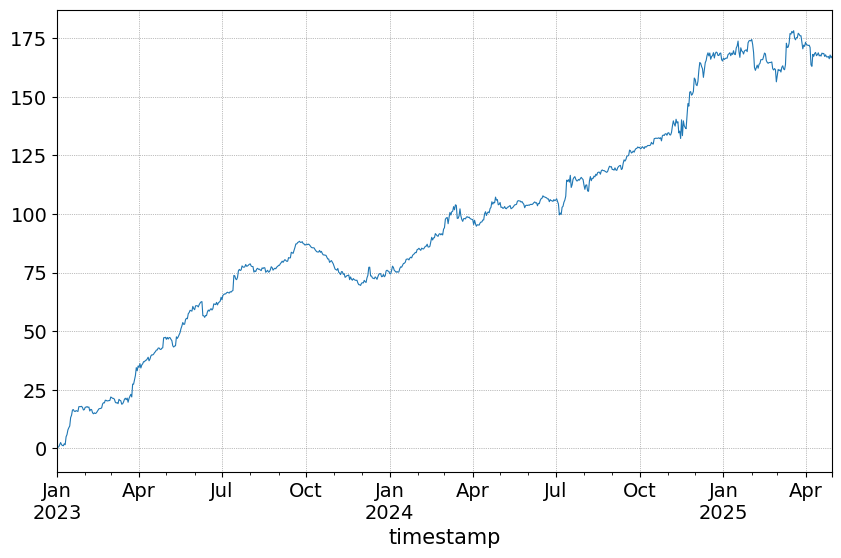

In [230]:
from datetime import time
raw_ret = close_1m.XRP.between_time(time(1, 30), time(5, 30)).resample("1D").agg(["first", "last"]).pct_change(axis=1).iloc[:, -1].rename("ret").mul(1e4)
raw_ret.cumsum().div(1e2).plot();
raw_ret.describe().to_frame().T

In [231]:
# Run
from etr.research.tod.v1 import run_tod

results = []
for params in tqdm(ParameterGrid({
    "sl_level": [np.nan, 300, 500],
    "entry_duration": [0, 5],
    "exit_duration": [0, 5],
    "entry_offset": [0, 1, 3, 5],
    "exit_offset": [0, 1, 3, 5],
})):
    trs = run_tod(data, st=time(1, 25), et=time(5, 35), **params).set_index("timestamp")
    assert trs.entry_side.eq(1).all()
    desc = trs.pl.describe().rename(lambda x: f"pl_{x}")
    desc["sharpe"] = desc["pl_mean"] / desc["pl_std"] * np.sqrt(365)
    desc["MDD"] = (trs.pl.cumsum() - trs.pl.cumsum().cummax()).min() / 1e2
    desc = desc.rename(str(params)).to_frame().T
    results.append(desc)

results = pd.concat(results)
params = pd.DataFrame(results.rename(lambda x: eval(x.replace("nan", "None"))).index.tolist())
params = params.set_index(results.index)
results = results.join(params)

100%|██████████| 192/192 [03:20<00:00,  1.05s/it]


In [232]:
results.sort_values("sharpe", ascending=False).drop_duplicates("pl_mean").head(10).style.format(precision=2)

,pl_count,pl_mean,pl_std,pl_min,pl_25%,pl_50%,pl_75%,pl_max,sharpe,MDD,entry_duration,entry_offset,exit_duration,exit_offset,sl_level
"{'entry_duration': 0, 'entry_offset': 5, 'exit_duration': 0, 'exit_offset': 3, 'sl_level': 300}",851.00,15.25,136.08,-303.91,-49.69,5.89,73.58,860.96,2.14,-19.64,0,5,0,3,300.00
"{'entry_duration': 0, 'entry_offset': 0, 'exit_duration': 5, 'exit_offset': 0, 'sl_level': 300}",851.00,14.92,134.99,-303.91,-48.02,5.57,71.51,887.60,2.11,-20.15,0,0,5,0,300.00
"{'entry_duration': 0, 'entry_offset': 3, 'exit_duration': 5, 'exit_offset': 5, 'sl_level': 300}",851.00,14.87,135.49,-303.91,-48.37,5.63,71.45,855.84,2.10,-19.24,0,3,5,5,300.00
"{'entry_duration': 0, 'entry_offset': 3, 'exit_duration': 5, 'exit_offset': 3, 'sl_level': 300}",851.00,14.39,135.25,-303.91,-48.36,5.19,71.48,854.37,2.03,-20.04,0,3,5,3,300.00
"{'entry_duration': 0, 'entry_offset': 1, 'exit_duration': 5, 'exit_offset': 1, 'sl_level': 300}",851.00,13.88,135.03,-303.91,-49.07,4.84,71.24,852.19,1.96,-20.42,0,1,5,1,300.00
"{'entry_duration': 0, 'entry_offset': 3, 'exit_duration': 0, 'exit_offset': 5, 'sl_level': nan}",851.00,14.92,149.97,-856.43,-48.91,5.97,75.03,860.96,1.90,-21.18,0,3,0,5,nan
"{'entry_duration': 0, 'entry_offset': 5, 'exit_duration': 5, 'exit_offset': 0, 'sl_level': nan}",851.00,13.86,148.83,-798.24,-47.64,5.57,72.44,887.60,1.78,-20.96,0,5,5,0,nan
"{'entry_duration': 0, 'entry_offset': 5, 'exit_duration': 5, 'exit_offset': 5, 'sl_level': nan}",851.00,13.78,148.94,-793.61,-48.07,5.63,72.17,855.84,1.77,-20.56,0,5,5,5,nan
"{'entry_duration': 5, 'entry_offset': 0, 'exit_duration': 0, 'exit_offset': 1, 'sl_level': 300}",851.00,12.44,134.52,-303.90,-49.84,4.37,69.58,860.96,1.77,-22.25,5,0,0,1,300.00
"{'entry_duration': 0, 'entry_offset': 0, 'exit_duration': 0, 'exit_offset': 0, 'sl_level': 500}",851.00,13.45,147.32,-503.81,-49.69,5.72,74.20,860.96,1.74,-23.28,0,0,0,0,500.00


---
### 0700-1230

,count,mean,std,min,25%,50%,75%,max
ret,851.0,18.45149,170.156772,-1033.259424,-54.434773,8.635687,72.633688,1021.375697


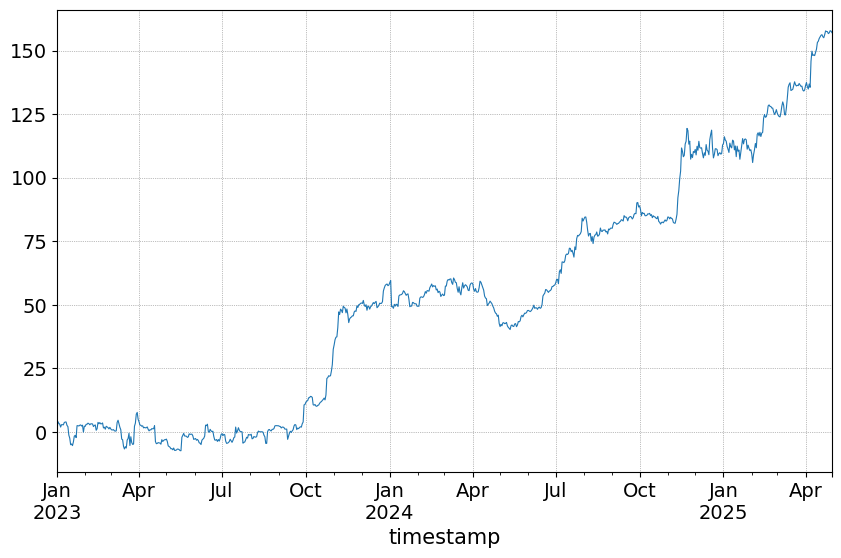

In [233]:
from datetime import time
raw_ret = close_1m.XRP.between_time(time(7, 0), time(12, 30)).resample("1D").agg(["first", "last"]).pct_change(axis=1).iloc[:, -1].rename("ret").mul(1e4)
raw_ret.cumsum().div(1e2).plot();
raw_ret.describe().to_frame().T

In [235]:
# Run
from etr.research.tod.v1 import run_tod

results = []
for params in tqdm(ParameterGrid({
    "sl_level": [np.nan, 300, 500],
    "entry_duration": [0, 5],
    "exit_duration": [0, 5],
    "entry_offset": [0, 1, 3, 5],
    "exit_offset": [0, 1, 3, 5],
})):
    trs = run_tod(data, st=time(7, 0), et=time(12, 30), **params).set_index("timestamp")
    assert trs.entry_side.eq(1).all()
    desc = trs.pl.describe().rename(lambda x: f"pl_{x}")
    desc["sharpe"] = desc["pl_mean"] / desc["pl_std"] * np.sqrt(365)
    desc["MDD"] = (trs.pl.cumsum() - trs.pl.cumsum().cummax()).min() / 1e2
    desc = desc.rename(str(params)).to_frame().T
    results.append(desc)

results = pd.concat(results)
params = pd.DataFrame(results.rename(lambda x: eval(x.replace("nan", "None"))).index.tolist())
params = params.set_index(results.index)
results = results.join(params)

100%|██████████| 192/192 [03:21<00:00,  1.05s/it]


In [236]:
results.sort_values("sharpe", ascending=False).drop_duplicates("pl_mean").head(10).style.format(precision=2)

,pl_count,pl_mean,pl_std,pl_min,pl_25%,pl_50%,pl_75%,pl_max,sharpe,MDD,entry_duration,entry_offset,exit_duration,exit_offset,sl_level
"{'entry_duration': 0, 'entry_offset': 0, 'exit_duration': 0, 'exit_offset': 0, 'sl_level': nan}",851.00,11.68,171.60,-1047.03,-61.32,1.76,67.69,983.72,1.30,-29.63,0,0,0,0,nan
"{'entry_duration': 0, 'entry_offset': 1, 'exit_duration': 0, 'exit_offset': 1, 'sl_level': 500}",851.00,11.10,168.89,-503.85,-61.32,1.76,66.87,983.72,1.26,-27.72,0,1,0,1,500.00
"{'entry_duration': 0, 'entry_offset': 1, 'exit_duration': 5, 'exit_offset': 0, 'sl_level': nan}",851.00,9.96,169.52,-1086.04,-59.56,2.50,64.31,887.42,1.12,-31.68,0,1,5,0,nan
"{'entry_duration': 0, 'entry_offset': 5, 'exit_duration': 5, 'exit_offset': 5, 'sl_level': nan}",851.00,9.85,169.76,-1081.50,-61.89,1.12,64.40,892.89,1.11,-30.58,0,5,5,5,nan
"{'entry_duration': 0, 'entry_offset': 0, 'exit_duration': 5, 'exit_offset': 0, 'sl_level': 500}",851.00,9.63,166.48,-503.85,-59.87,2.50,62.73,901.78,1.11,-29.11,0,0,5,0,500.00
"{'entry_duration': 0, 'entry_offset': 5, 'exit_duration': 5, 'exit_offset': 5, 'sl_level': 500}",851.00,9.59,166.52,-503.85,-61.89,1.12,64.32,901.78,1.10,-28.56,0,5,5,5,500.00
"{'entry_duration': 0, 'entry_offset': 3, 'exit_duration': 5, 'exit_offset': 3, 'sl_level': nan}",851.00,9.68,169.26,-1083.27,-61.64,0.79,63.71,890.73,1.09,-30.83,0,3,5,3,nan
"{'entry_duration': 0, 'entry_offset': 1, 'exit_duration': 5, 'exit_offset': 3, 'sl_level': 500}",851.00,9.40,166.15,-503.85,-61.64,0.79,62.91,901.78,1.08,-28.57,0,1,5,3,500.00
"{'entry_duration': 5, 'entry_offset': 5, 'exit_duration': 0, 'exit_offset': 1, 'sl_level': nan}",851.00,9.53,170.61,-1037.89,-63.34,-0.47,63.70,914.66,1.07,-34.49,5,5,0,1,nan
"{'entry_duration': 0, 'entry_offset': 3, 'exit_duration': 5, 'exit_offset': 1, 'sl_level': nan}",851.00,9.14,169.61,-1085.04,-59.62,0.51,62.46,888.57,1.03,-32.09,0,3,5,1,nan


---

## Consolidated

In [174]:
interval1, interval2, interval4

([datetime.time(1, 30), datetime.time(5, 30)],
 [datetime.time(7, 0), datetime.time(12, 30)],
 [datetime.time(16, 20), datetime.time(20, 30)])

In [237]:
trs = pd.concat([
    run_tod(data, st=time( 1, 25), et=time( 5, 30), sl_level=300, entry_duration=0, exit_duration=0),
    run_tod(data, st=time( 7,  0), et=time(12, 30), sl_level=500, entry_duration=0, exit_duration=0),
    run_tod(data, st=time(16, 20), et=time(20, 30), sl_level=500, entry_duration=0, exit_duration=0),
]).set_index("timestamp").sort_index()

<Axes: xlabel='timestamp'>

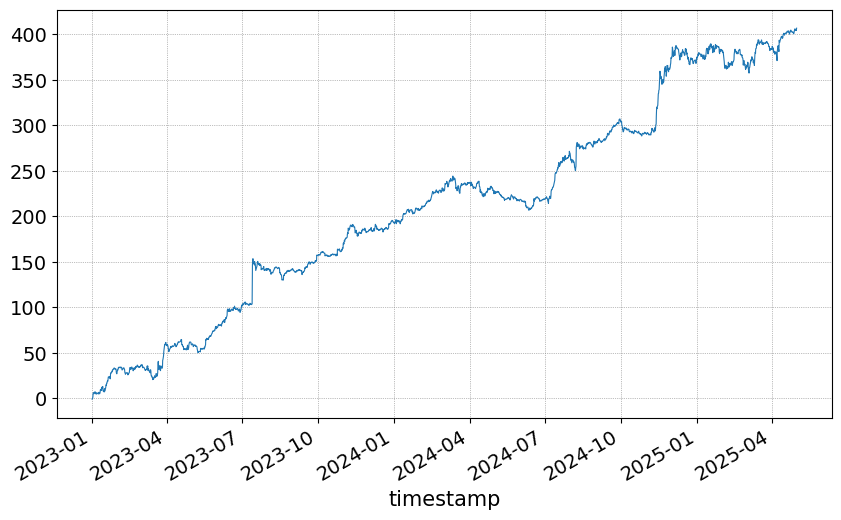

In [238]:
trs.pl.cumsum().div(1e2).plot()

In [250]:
trs.resample("1M").pl.sum().div(1e2).to_frame().style.bar().format(precision=2)

,pl
timestamp,
2023-01-31 00:00:00,30.38
2023-02-28 00:00:00,4.68
2023-03-31 00:00:00,23.86
2023-04-30 00:00:00,0.52
2023-05-31 00:00:00,18.59
2023-06-30 00:00:00,24.41
2023-07-31 00:00:00,40.12
2023-08-31 00:00:00,-1.85
2023-09-30 00:00:00,16.17


In [254]:
trs.resample("1M").pl.sum().div(1e2).describe().to_frame("Return[M]").T

,count,mean,std,min,25%,50%,75%,max
Return[M],28.0,14.532547,20.449937,-17.253297,0.489616,13.910874,22.365965,84.633386


In [257]:
10 * (14 * 12) / 100

16.8